# Import des librairies + paramètres

In [1]:
import warnings; warnings.simplefilter('ignore')
import P5_toolbox        as p5

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# to show and store figures in the notebook
%matplotlib inline

# Données de la slide de présentation

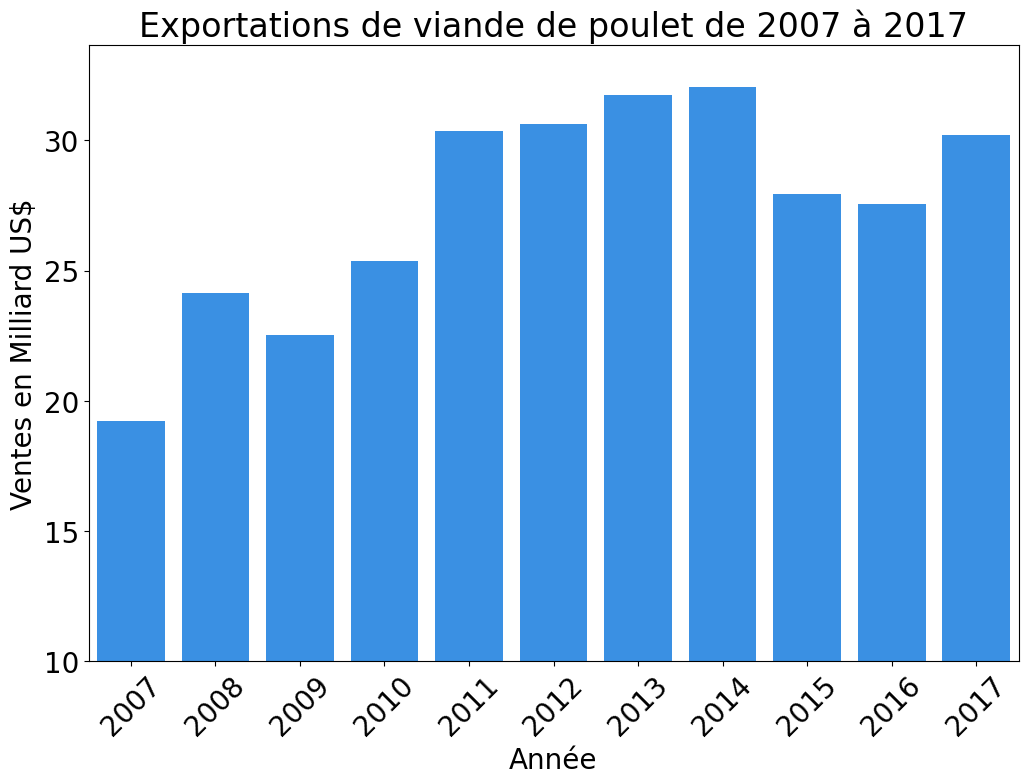

In [2]:
# loading dataset
sales = pd.read_csv('./dataset/FAOSTAT_2007_2017_import_export_chicken.csv',
                             usecols=['Element Code', 'Year', 'Value'])

# selecting export values
sales = sales[sales['Element Code']==5922]

# visual result
sales = sales[['Year', 'Value']].groupby('Year').sum().reset_index()
sales['Value'] = np.divide(sales['Value'], 10**6) 

plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))

sns.barplot(x='Year', y='Value', data=sales, color='dodgerblue')

plt.title("Exportations de viande de poulet de 2007 à 2017")
plt.axis(ymin=10)
plt.xlabel('Année')
plt.xticks(rotation=45)
plt.ylabel('Ventes en Milliard US$')

plt.show();

In [3]:
sales.iloc[10]

Year     2017.000000
Value      30.229471
Name: 10, dtype: float64

In [4]:
# to compute sales_growth
sales = np.array(sales)
sales = sales[sales[:, 0].argsort()][::-1]

# copy sales then concatenate with shifted array
sales = np.concatenate((sales[:-1], sales[1:, 1].reshape(-1,1)), axis=1)
np.mean(np.divide((sales[:, 1] - sales[:, 2]), sales[:, 2]))

0.052172097945509074

# Construction des variables / dataset

## growth_rate 
**Problème rencontré** : pour calculer un delta de population, j'ai besoin de N+1 échantillons d'années.

**Solution** : charger une année supplémentaire de population.

**Problème rencontré** : La Chine génère des doublons avec ses régions.

**Solution** : décocher les régions de Chine lors du prélèvement de données.Vérifier pour chaque fichier une fois le processus terminé.


In [5]:
# preparing data
growth_rate = pd.read_csv('./dataset/FAOSTAT_2006_2017_population.csv',
                         usecols=['Area', 'Year', 'Value'])

gr_columns = growth_rate.columns
growth_rate = np.array(growth_rate)

# sorting by 'Area', then 'Year' DESC ==> [::-1]
multi_index = np.core.records.fromarrays([growth_rate[:,0],growth_rate[:,1]])
growth_rate = growth_rate[multi_index.argsort()][::-1]

# preparing vectorial computation
growth_rate = np.concatenate((growth_rate[:-1], growth_rate[1:,[0,2]]), axis=1)

# droping rows where 'Area Code' != 'Area Code'(shifted_array)
growth_rate = growth_rate[growth_rate[:, 0]==growth_rate[:, 3]]
growth_rate = growth_rate[:,[0, 1, 2, 4]]

# vectorial computation
growth_rate[:, 2] = ((growth_rate[:, 2] - growth_rate[:, 3]) / growth_rate[:, 3]) * 1000
growth_rate = growth_rate[:, [0, 1, 2]]

# selecting year 2017
growth_rate = growth_rate[growth_rate[:, 1]==2017]
growth_rate = growth_rate[:,[0,2]]

# visual result
pd.DataFrame(growth_rate, columns=['Area', 'growth_rate']).set_index('Area')

,growth_rate
Area,
Zimbabwe,14.7013
Zambia,29.9534
Yemen,24.5364
Western Sahara,25.7374
Wallis and Futuna Islands,-17.0975
...,...
Andorra,-3.82939
American Samoa,-2.17075
Algeria,20.6601


## protein_ratio

In [6]:
# data preparation
food_supply = pd.concat( [pd.read_csv('./dataset/FAOSTAT_2007_2013_food_supply.csv', 
                            usecols=['Area', 'Year', 'Value', 'Item Code', 'Element Code']),
                          pd.read_csv('./dataset/FAOSTAT_2014_2017_food_supply.csv', 
                            usecols=['Area', 'Year', 'Value', 'Item Code', 'Element Code'])])

# 674 : protein supply
protein_ratio = food_supply[food_supply['Element Code']==674]

# array [Area, Year, 2903 veg , 2941 ani]
protein_ratio = np.array(  food_supply.pivot_table(index=['Area','Year'],
                                                   columns='Item Code',
                                                   values='Value',
                                                   fill_value=0).reset_index())

# vectorial computation
protein_ratio[:, 2] = np.divide(protein_ratio[:, 3], 
                                np.sum((protein_ratio[:, 2], protein_ratio[:, 3]), axis=0))

protein_ratio[:, 2] = np.multiply(protein_ratio[:, 2], 100)

# selecting year 2017
protein_ratio = protein_ratio[protein_ratio[:, 1]==2017]
protein_ratio = protein_ratio[:, [0, 2]]

# visual result
pd.DataFrame(protein_ratio, columns=['Area', 'protein_ratio']).set_index('Area')

,protein_ratio
Area,
Afghanistan,9.81213
Albania,32.9778
Algeria,12.4846
Angola,9.87389
Antigua and Barbuda,31.8963
...,...
Venezuela (Bolivarian Republic of),15.2119
Viet Nam,22.5166
Yemen,7.26103


## supply_prot

In [7]:
# data preparation
supply_prot = np.array(food_supply[(food_supply['Item Code']==2941) & (food_supply['Element Code']==674)])

# selecting year 2017
supply_prot = supply_prot[supply_prot[:, 3]==2017]
supply_prot = supply_prot[:, [0, 4]]

# visual result
pd.DataFrame(supply_prot, columns=['Area', 'supply_prot']).set_index('Area')

,supply_prot
Area,
Afghanistan,10.55
Albania,66.34
Algeria,25.71
Angola,16.48
Antigua and Barbuda,54.06
...,...
Venezuela (Bolivarian Republic of),25.37
Viet Nam,36.81
Yemen,10.66


## energetic_mean
La disponibilité alimentaire en kcal par habitant, est une moyenne de l'ensemble des produits disponibles. 
Nous souhaitons faire un profilage de pays sur les protéines, nous baserons donc notre étude uniquement sur les produits d'origine animale. Cette variable mesure l'habitude alimentaire du pays : viande maigre (poulet), viande mi-maigre et viande grasse. plus cette variable est élevée, plus le pays consomme de la viande grasse, car c'est le gras qui donne une haute valeur calorique à la viande.

In [8]:
# data preparation 2941 : animal products 664 : food supply
energetic_mean = np.array(food_supply[(food_supply['Item Code']==2941) & (food_supply['Element Code']==664)])

# selecting year 2017
energetic_mean = energetic_mean[energetic_mean[:, 3]==2017]
energetic_mean = energetic_mean[:, [0, 4]]

# visual result
pd.DataFrame(energetic_mean, columns=['Area', 'energetic_mean']).set_index('Area')

,energetic_mean
Area,
Afghanistan,191
Albania,1094
Algeria,404
Angola,213
Antigua and Barbuda,747
...,...
Venezuela (Bolivarian Republic of),325
Viet Nam,645
Yemen,143


## importc_ratio
Cette variable représente le ratio des importations sur la consommation du pays. Elle servira de variable indépendante pour la régression multiple, régression multiple qui sert à détecter les outliers contenus dans les relations entre les variables étudiées grâce au graphique d'infuence.

In [9]:
element_list = np.array(pd.read_csv('./dataset/FAOSTAT_2007_2013_poultry_meat.csv',
                                     usecols=['Element Code', 'Element', 'Unit']))

element_list = element_list[element_list[:, 1].argsort()]
element_list[np.unique(element_list[:, 1], return_index=True)[1]]

array([[5142, 'Food', '1000 tonnes'],
       [5611, 'Import Quantity', '1000 tonnes']], dtype=object)

In [10]:
# data preparation
importc_ratio = pd.concat( [pd.read_csv('./dataset/FAOSTAT_2007_2013_poultry_meat.csv', 
                            usecols=['Area', 'Year', 'Value', 'Element Code']),
                          pd.read_csv('./dataset/FAOSTAT_2014_2017_poultry_meat.csv', 
                            usecols=['Area', 'Year', 'Value', 'Element Code'])])


importc_ratio = importc_ratio.pivot_table(index=['Area', 'Year'],
                                          columns='Element Code',
                                          values='Value',
                                          fill_value=0).reset_index()

# array Area 	Year	5142	5611
importc_ratio = np.array(importc_ratio)

# vectorial computation
importc_ratio[:, 2] = np.divide(importc_ratio[:, 3], importc_ratio[:, 2])
importc_ratio[:, 2] = np.multiply(importc_ratio[:, 2], 100)

# selecting year 2017
importc_ratio = importc_ratio[importc_ratio[:, 1]==2017]
importc_ratio = importc_ratio[:, [0, 2, 3]]

# visual result
pd.DataFrame(importc_ratio, columns=['Area', 'importc_ratio', 'import_quantity'])

,Area,importc_ratio,import_quantity
0,Afghanistan,52.7273,29
1,Albania,80.8511,38
2,Algeria,0.757576,2
3,Angola,87.9365,277
4,Antigua and Barbuda,140,7
...,...,...,...
162,Venezuela (Bolivarian Republic of),4.19463,25
163,Viet Nam,24.9571,291
164,Yemen,32.9114,78
165,Zambia,20.6897,12


In [11]:
# data preparation
chicken_poultry_ratio = pd.read_csv('./dataset/FAOSTAT_2007_2017_import_export_chicken.csv',
                                     usecols=['Area', 'Year', 'Element Code', 'Value'])


chicken_poultry_ratio = chicken_poultry_ratio[chicken_poultry_ratio['Element Code']==5610]

# group by chicken meat(1058) + chicken canned(1061) with np.sum
chicken_poultry_ratio = chicken_poultry_ratio.pivot_table(index=['Area', 'Year'],
                                                          columns='Element Code',
                                                          values='Value',
                                                          aggfunc=np.sum,
                                                          fill_value=0).reset_index()

# vectorial computation
chicken_poultry_ratio = np.array(chicken_poultry_ratio)
chicken_poultry_ratio[:, 2] = np.divide(chicken_poultry_ratio[:, 2], 1000)

# selecting year 2017
chicken_poultry_ratio = chicken_poultry_ratio[chicken_poultry_ratio[:, 1]==2017]
chicken_poultry_ratio = chicken_poultry_ratio[:, [0, 2]]

# visual result
pd.DataFrame(chicken_poultry_ratio, columns=['Area', 'chicken_poultry_ratio'])

,Area,chicken_poultry_ratio
0,Afghanistan,29.141
1,Albania,37.555
2,Algeria,1.66
3,American Samoa,0.001
4,Angola,266.647
...,...,...
194,Venezuela (Bolivarian Republic of),23.121
195,Viet Nam,355.721
196,Yemen,81.779
197,Zambia,12.015


In [12]:
# data preparation
importc_ratio = np.array(
pd.merge(pd.DataFrame(importc_ratio, columns=['Area', 'importc_ratio', 'import_quantity']),
         pd.DataFrame(chicken_poultry_ratio, columns=['Area', 'chicken_poultry_ratio'])))

importc_ratio = importc_ratio[importc_ratio[:, 2]!=0]

# vectorial computation
importc_ratio[:, 2] = np.divide(importc_ratio[:, 3], importc_ratio[:, 2])
importc_ratio[:, 1] = np.multiply(importc_ratio[:, 1], importc_ratio[:, 2])
importc_ratio = importc_ratio[:, [0, 2]]

# visual result
pd.DataFrame(importc_ratio, columns=['Area', 'importc_ratio']).set_index('Area')

,importc_ratio
Area,
Afghanistan,1.00486
Albania,0.988289
Algeria,0.83
Angola,0.962625
Antigua and Barbuda,0.917571
...,...
Venezuela (Bolivarian Republic of),0.92484
Viet Nam,1.22241
Yemen,1.04845


# Création du dataset

In [13]:
retained_data = pd.DataFrame(importc_ratio,
                             columns=['country', 'import/consumption_chicken'])

retained_data = retained_data.merge(
    pd.DataFrame(growth_rate,
                 columns=['country', 'growth_rate']))

retained_data = retained_data.merge(
    pd.DataFrame(protein_ratio,
                 columns=['country', 'protein_ratio']))

retained_data = retained_data.merge(
    pd.DataFrame(supply_prot, columns=['country', 'supply_prot']))

retained_data = retained_data.merge(
    pd.DataFrame(energetic_mean, columns=['country', 'energetic_mean']))

retained_data

,country,import/consumption_chicken,growth_rate,protein_ratio,supply_prot,energetic_mean
0,Afghanistan,1.00486,25.8056,9.81213,10.55,191
1,Albania,0.988289,-0.78609,32.9778,66.34,1094
2,Algeria,0.83,20.6601,12.4846,25.71,404
3,Angola,0.962625,33.7792,9.87389,16.48,213
4,Antigua and Barbuda,0.917571,9.51051,31.8963,54.06,747
...,...,...,...,...,...,...
143,Venezuela (Bolivarian Republic of),0.92484,-15.0336,15.2119,25.37,325
144,Viet Nam,1.22241,10.2544,22.5166,36.81,645
145,Yemen,1.04845,24.5364,7.26103,10.66,143
146,Zambia,1.00125,29.9534,6.9828,11.69,133


# Nettoyage des outliers
### Je vais utiliser une ACP : tous les pays doivent avoir le même poids.Il faut donc enlever les pays qui ont une plus grande influence que les autres.Pour cela, j'utilise un graphique d'influence avec une variable de contrôle qui va étalonner l'influence des pays. J'ai choisi le ratio importation/consommation de poulet qui me semble un bon étalon puisqu'on veut exporter notre production dans les pays qui en ont le plus besoin.

L'effet de levier est une mesure de la distance qui sépare les valeurs de la variable indépendante de celles des autres observations.

La distance de Cook mesure l'effet de la suppression d'une valeur dont le résidu est important, impliquant un impact plus important dans la regression.

Les résidus studentisés sont les résidus divisé par l'écart-type.

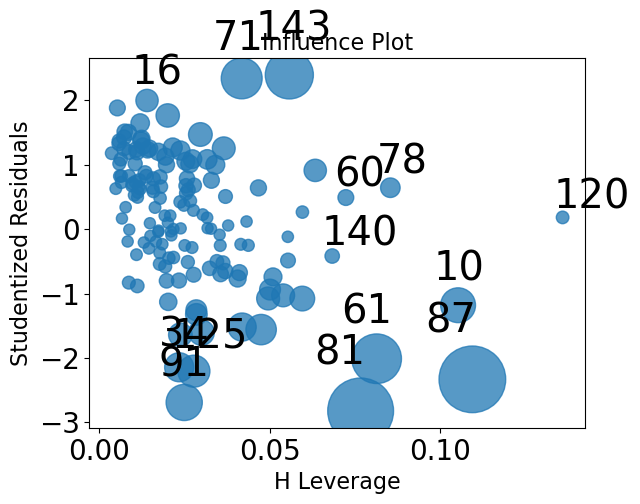

                                country growth_rate supply_prot
143  Venezuela (Bolivarian Republic of)    -15.0336       25.37
16               Bosnia and Herzegovina    -10.2594       34.73
71                             Kiribati     14.5213        36.9
60                              Hungary    -2.37384       49.81
78                            Lithuania    -15.2767       77.02
140            United States of America     6.40452       73.87
120                            Slovakia     1.08361       36.91
10                              Bahamas     10.1209       42.01
87                             Mongolia     18.7877       56.14
61                              Iceland     6.58326      100.92
81                             Maldives     43.9316        49.1
1                               Albania    -0.78609       66.34
2                               Algeria     20.6601       25.71
3                                Angola     33.7792       16.48
4                   Antigua and Barbuda 

In [14]:
from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.api as sm

y = np.array(retained_data.iloc[:, 1], dtype=float).reshape(-1, 1)
X = np.array(retained_data.iloc[:, 2:], dtype=float)

model = sm.OLS(y,X)
results = model.fit()
#print(results.summary())

influence_plot(results, criterion="cooks")
plt.show()

# outliers droping
index = [143, 16, 71, 60, 78, 140, 120, 10, 87, 61, 81, 1, 2, 3, 4, 5, 91]
print (retained_data.loc[index][['country', 'growth_rate', 'supply_prot']])
outliers = retained_data.loc[index].set_index('country')
retained_data = retained_data.drop(index=index)

## Nettoyage des outliers : suite à ACP
Il y a des points vraiment éloignés quand on réalise la projection des individus. Ce sont des données aberrantes/atypiques.

In [15]:
retained_data = retained_data.set_index('country')

country_outliers = ['Luxembourg', 'Gabon', 'Kuwait', 'Chad', 'Mali', 'Mauritania', 
                    'Australia', 'Niger', 'Oman', 'Latvia', 'Portugal']

print (retained_data.loc[country_outliers][['growth_rate', 'supply_prot']])

outliers = pd.concat([outliers, retained_data.loc[country_outliers]])

retained_data = retained_data.drop(index=country_outliers)

           growth_rate supply_prot
country                           
Luxembourg     21.8312       67.39
Gabon          28.3633       38.78
Kuwait         25.0764       47.43
Chad           31.2528       21.77
Mali           30.4466       23.19
Mauritania     28.5904       29.44
Australia      13.2676        71.3
Niger          39.1357       12.48
Oman           41.6834        42.2
Latvia        -11.7355       55.63
Portugal      -3.58441       72.72


# Utiliser la technologie mathématique ACP
Réduire la complexité superflue d'un dataset en projetant les données dans un espace de plus petite dimension.

Projeter les données sur des axes (composantes principales), en cherchant à minimiser la distance entre les points et leurs projections.

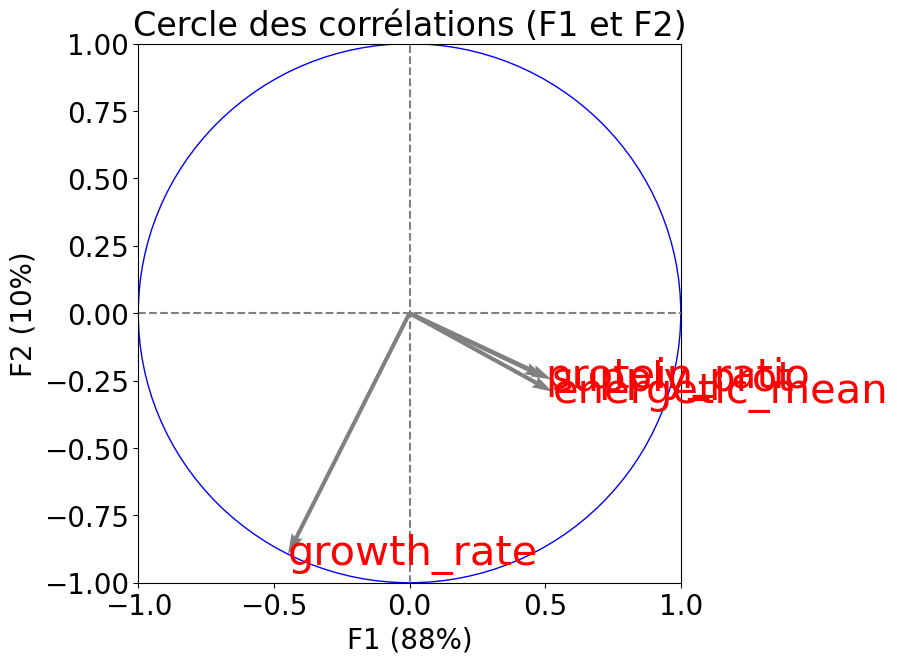

,growth_rate,protein_ratio,supply_prot,energetic_mean
1,-0.447992,0.498892,0.522869,0.526324
2,-0.893519,-0.237896,-0.245613,-0.291040


In [16]:
p5.pca_pareto_diagram_corr_circle(retained_data.iloc[:, [1, 2, 3, 4]])

## Matrice des corrélations : vérification des 3 variables projetées de la même manière
Les 3 variables ciblées calculent les mêmes données.On peut simplifier l'information en gardant la variable la mieux projetée.

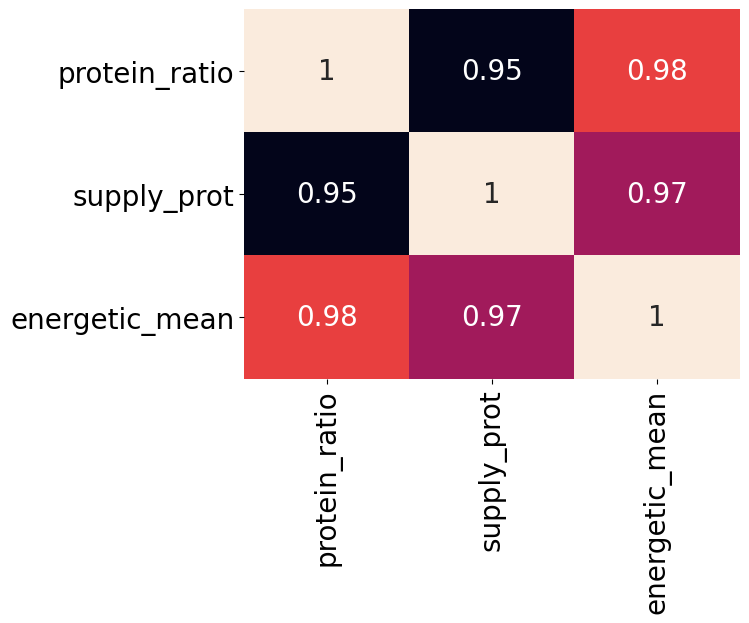

In [17]:
retained_data = retained_data.astype('float')
sns.heatmap(retained_data.iloc[:, 2:5].corr().round(2), annot=True, cbar=False);

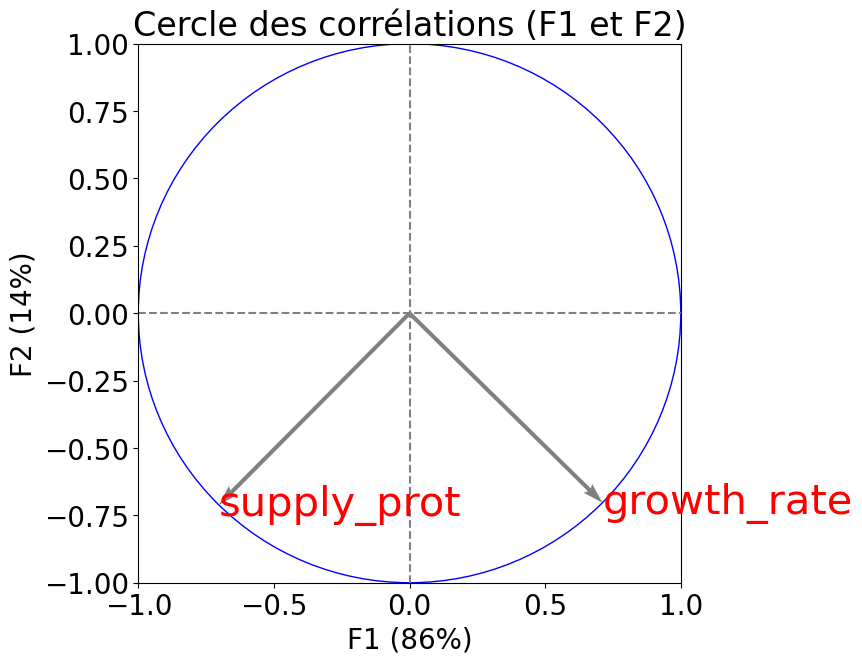

In [18]:
matrix = p5.pca_pareto_diagram_corr_circle(retained_data.iloc[:, [1, 3]])

### Intégration des axes d'inertie dans le dataframe

In [19]:
matrix

,growth_rate,supply_prot
1,0.711235,-0.702954
2,-0.702954,-0.711235


In [20]:
from sklearn.preprocessing import RobustScaler
standardized_data = RobustScaler().fit_transform(retained_data)

F1 = standardized_data[:, 1] * matrix.iloc[0, 0] + standardized_data[:, 3] * matrix.iloc[0, 1]
F2 = standardized_data[:, 1] * matrix.iloc[1, 0] + standardized_data[:, 3] * matrix.iloc[1, 1]

retained_data['F1'] = F1
retained_data['F2'] = F2

retained_data

,import/consumption_chicken,growth_rate,protein_ratio,supply_prot,energetic_mean,F1,F2
country,,,,,,,
Afghanistan,1.004862,25.805618,9.812131,10.55,191.0,1.296504,-0.067694
Armenia,0.993657,2.945361,26.282524,44.57,790.0,-0.580460,0.155055
Austria,0.649500,8.299703,32.039946,64.88,1153.0,-0.819218,-0.583490
Azerbaijan,0.915926,11.223964,16.809113,30.11,507.0,0.150601,0.126332
Barbados,0.352500,1.525564,25.135918,50.37,700.0,-0.785486,0.079396
...,...,...,...,...,...,...,...
Vanuatu,0.881250,25.796716,15.495789,25.33,391.0,0.941526,-0.426028
Viet Nam,1.222409,10.254396,22.516620,36.81,645.0,-0.055122,0.008178
Yemen,1.048449,24.536436,7.261026,10.66,143.0,1.234969,-0.012152


### Trouver les variables synthétiques 

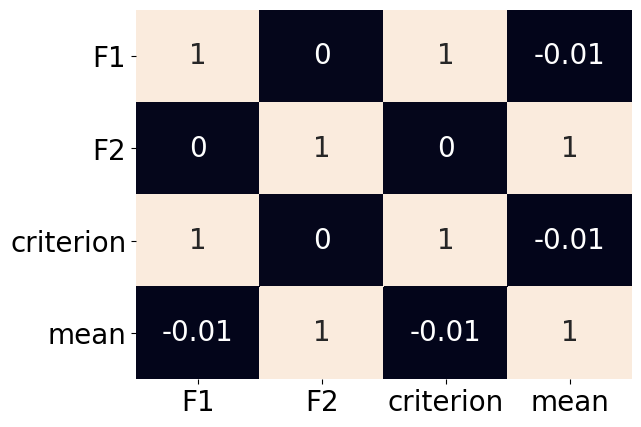

In [21]:
# standardization
from sklearn.preprocessing import RobustScaler
standardized_data = RobustScaler().fit_transform(retained_data.iloc[:, [1, 3]])

# testing insight : F1
pi = 3.1415926535897323
retained_data['criterion'] = pi * (standardized_data[:, 0] - standardized_data[:, 1]) 

# testing insight : F2 
retained_data['mean'] = np.mean(standardized_data[:,[0,1]], axis=1) * -1

# visual result
sns.heatmap(retained_data.iloc[:, 5:9].corr().round(2), annot=True, cbar=False);

## Détecter les valeurs atypiques/aberrantes

In [22]:
#p5.factorial_plane(retained_data.iloc[:, [1, 3]], list(np.arange(retained_data.shape[0])), 
#                   labels=True, centroids=False)

# Construire le dendrogramme

## Le graphique du dendrogramme

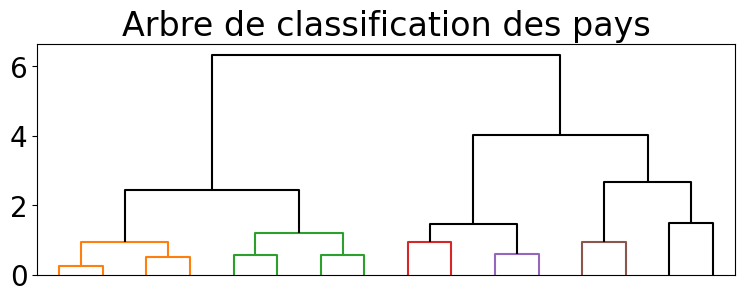

In [23]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

plt.figure(figsize=(9,3))
plt.title('Arbre de classification des pays')

linkage_matrix = linkage(retained_data.iloc[:, 7:9], method='median', metric='euclidean', optimal_ordering=True)

dendrogram(linkage_matrix,
           no_labels=True,
           truncate_mode='level', p=3,
           color_threshold=1.4,
           show_leaf_counts=False,
           above_threshold_color='black')

plt.savefig('P5_01_dendrogramme.png')
plt.show()

### Couper le dendrogramme
Un fichier CSV contenant la liste des pays ainsi que (pour chacun d'entre eux) leur groupe que vous aurez déterminé après avoir découpé le dendrogramme.Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 

In [24]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage

groups = fcluster(linkage_matrix, criterion='maxclust', t=7, depth=3)

retained_data['group'] = groups.reshape(-1,1)
retained_data.iloc[:,9].sort_values().to_csv('P5_03_groupes.csv')

## Déterminer les centroïdes
Un ficher CSV contenant les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.

In [25]:
centroids = retained_data.iloc[:, [1, 3, 7, 8, 9]].groupby('group').mean().round(2)

centroids = pd.DataFrame(centroids,
                         index=retained_data.iloc[:, [1, 3, 7, 8, 9]].groupby('group').mean().index,
                         columns=list(retained_data.iloc[:, [1, 3, 7, 8]].columns))

centroids.to_csv('P5_04_centroïdes.csv')

centroids

,growth_rate,supply_prot,criterion,mean
group,,,,
1,27.03,11.52,5.90,-0.11
2,19.86,19.80,3.55,-0.02
3,13.97,29.01,1.35,0.02
4,9.87,36.76,-0.32,0.02
5,5.70,44.86,-2.04,0.02
6,2.25,55.26,-3.86,-0.05
7,-0.63,64.77,-5.47,-0.12


## Dresser une courte liste de pays
Donnez une courte liste de pays à cibler, en présentant leurs caractéristiques. 

In [26]:
short_list = retained_data[retained_data['group']==4][['growth_rate', 'supply_prot', 'criterion', 'mean']]
short_list = short_list.sort_values(by='mean')
short_list

,growth_rate,supply_prot,criterion,mean
country,,,,
Chile,14.353892,45.52,-0.338203,-0.276350
United Arab Emirates,13.483951,43.83,-0.335332,-0.219133
Malaysia,13.687363,43.20,-0.226093,-0.215019
Mexico,11.707682,43.79,-0.695138,-0.160503
Viet Nam,10.254396,36.81,-0.244685,0.006011
Dominican Republic,11.095006,34.37,0.189219,0.020222
Fiji,5.800098,31.21,-0.557324,0.246879
El Salvador,5.031825,25.95,-0.150865,0.361695
Thailand,3.457989,26.18,-0.498125,0.409114


## Premier plan factoriel
Visualisation des individus dans l'espace des variables, triés par groupe.

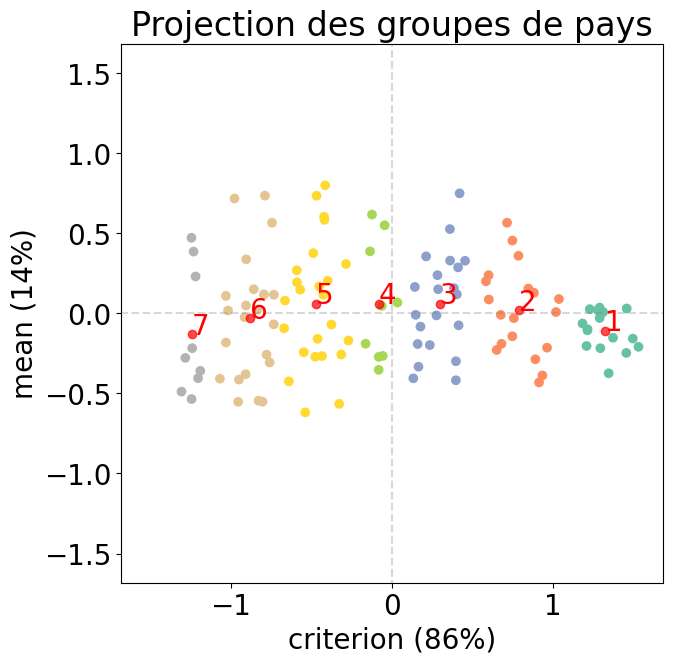

In [27]:
p5.factorial_plane(retained_data.iloc[:, [1, 3]], list(retained_data.iloc[:,9]), labels=False, centroids=True)

# Test d'adéquation
parmis les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale.

##  Tester la normalité d'une variable

## Test de shapiro wilk 
Le test de shapiro permet de tester la normalité d'une distribution.
L'hypothèse nulle est que la variable suit une loi normale.L' échantillon doit etre de petite taille.
Je fais donc un prélèvement aléatoire de la variable pour 10 valeurs. Je tire au hasard sans remise pour ne pas retomber sur la même valeur.

## Test de Kolmogorov-Smirnov
Le test de kolmogorov-smirnov compare 2 variables entre elles. Pour tester la normalité, cette autre variable sera une variable aléatoire 'normale' ayant la meme moyenne, le même écart-type et la même taille de la variable en question.


L'hypothèse nulle est : les 2 variables sont 2 échantillons d'une même population, compatibles avec la loi normale

In [76]:
def ks_shapiro_boolean(vector):
    '''
    return True if vector is gaussian-like with kolmogorov/smirnov and shapiro/wilk tests.
    '''
    
    from scipy import stats
    from sklearn.preprocessing import RobustScaler
       
    critical_threshold = 0.001
    shapiro_ok = False
    ks_ok = False
    
    # standardization
    X = vector.values.reshape(-1,1)
    standardized_X = RobustScaler().fit_transform(X)
    
    # shapiro test
    small_size_standardized_X = np.random.choice(standardized_X.reshape(-1), size=10, replace=False)
    if stats.shapiro(small_size_standardized_X)[1] >= critical_threshold:
        shapiro_ok = True
            
    # kolmogorov/smirnov test
    random_normal = np.random.normal(loc=standardized_X.mean(), 
                                     scale=standardized_X.std(), 
                                     size=(standardized_X.shape[0], 1))

    if stats.kstest(standardized_X.reshape(-1), random_normal.reshape(-1), 
                    N=standardized_X.shape[0])[1] >= critical_threshold :
        ks_ok = True

    if (shapiro_ok==True) & (ks_ok==True): 
        return True   

ks_shapiro_boolean(retained_data['criterion'])

True

# test de comparaison de deux populations (dans le cas gaussien) 
Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement.


choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.


On va réaliser un test de Student.


On a vérifié que la variable supply_prot est gaussienne.
On réduit les groupes pour avoir la même variance.
Chaque pays est indépendant.
L'hypothèse nulle : les groupes ont la même moyenne.
Seuil critique : standard 5%

In [59]:
def pvalue_matrix_boxplot_graph(column_name):
    
    from scipy import stats
    
    if ks_shapiro_boolean(retained_data[column_name]):
        
        # pvalue matrix creation
        nb_group = retained_data['group'].max() 
        
        group_list = np.arange(1, nb_group + 1)
        
        pvalue_matrix = pd.DataFrame(np.zeros((nb_group, nb_group), dtype=float), 
                                     index = group_list, 
                                     columns = group_list)
        
        for index in pvalue_matrix.index:
            for column in pvalue_matrix.columns:

                # t test : calculate pvalue : if >= 5% then print 1
                group_1 = retained_data[retained_data['group']==index][column_name]
                group_1 = group_1/group_1.std()

                group_2 = retained_data[retained_data['group']==column][column_name]
                group_2 = group_2/group_2.std()

                if stats.ttest_ind(group_1, group_2)[1] >= 0.05 :
                    pvalue_matrix.at[index, column] = 1
                    

        # visual results
        plt.title('Student Test p-value matrix')
        sns.heatmap(pvalue_matrix, cbar=False);

        #retained_data.loc[:, [column_name, 'group']].boxplot(column_name, by='group').set_title('');
        return pvalue_matrix.astype('bool')

### On a synthétisé les informations sur 2 dimensions : mean et criterion. On effectue un test de comparaison sur ces 2 variables.

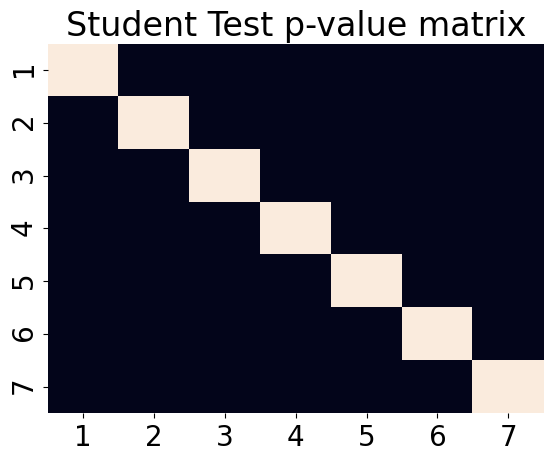

In [60]:
criterion = pvalue_matrix_boxplot_graph('criterion')

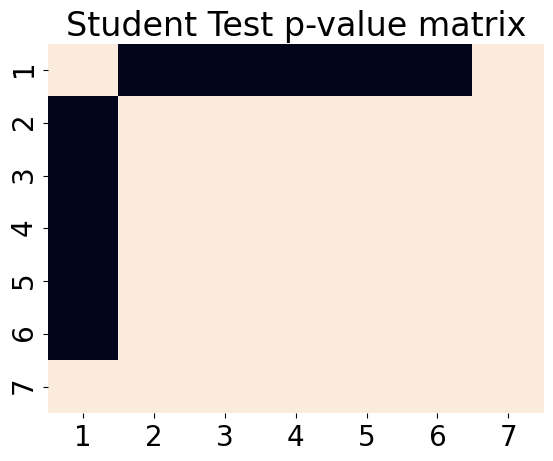

In [61]:
mean = pvalue_matrix_boxplot_graph('mean')

En vérifiant chaque pays du **groupe 1**, on s'aperçoit qu'il s'agit de pays qui ont connu la guerre en faisant une recherche google suivie du nom du pays. Donc instabilité en perspective, mais aussi marché potentiel à conquérir.

In [64]:
test = retained_data['supply_prot'].values